# **Siniestros Viales**
### **2. EDA - Análisis Exploratorio de Datos**

In [1]:
# Importando Librerías
import re
import sketch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary

### **Carga del dataset limpio `siniestros_viales**

In [2]:
sv= pd.read_csv("data/siniestos_viales.csv")
sv.head(3)

,Id,Fecha,Año,Mes,Día,Día semana,Hora completa,Hora,Num víctimas,Participantes,...,Calle,Cruce,Dirección normalizada,Comuna,Barrios,Xy (caba),Coordenada x,Coordenada y,Pos x,Pos y
0,2016-0001,2016-01-01,2016.0,1.0,1.0,Viernes,04:00:00,4.0,1,MOTO-AUTO,...,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.475340,-34.687570
1,2016-0002,2016-01-02,2016.0,1.0,2.0,Sabado,01:15:00,1.0,1,AUTO-PASAJEROS,...,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.508775,-34.669777
2,2016-0003,2016-01-03,2016.0,1.0,3.0,Domingo,07:00:00,7.0,1,MOTO-AUTO,...,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.390403,-34.631894


In [3]:
# Visualizamos información
sv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     717 non-null    object 
 1   Fecha                  702 non-null    object 
 2   Año                    702 non-null    float64
 3   Mes                    702 non-null    float64
 4   Día                    702 non-null    float64
 5   Día semana             702 non-null    object 
 6   Hora completa          702 non-null    object 
 7   Hora                   701 non-null    float64
 8   Num víctimas           717 non-null    int64  
 9   Participantes          702 non-null    object 
 10  Rol                    717 non-null    object 
 11  Acusado                702 non-null    object 
 12  Victima                702 non-null    object 
 13  Sexo                   717 non-null    object 
 14  Edad                   717 non-null    int64  
 15  Rango 

### **Identificación de Outliers**

Procedemos a buscar aquellos datos con valores atípicos en las features, y se analiza si es necesario eliminarlos. 

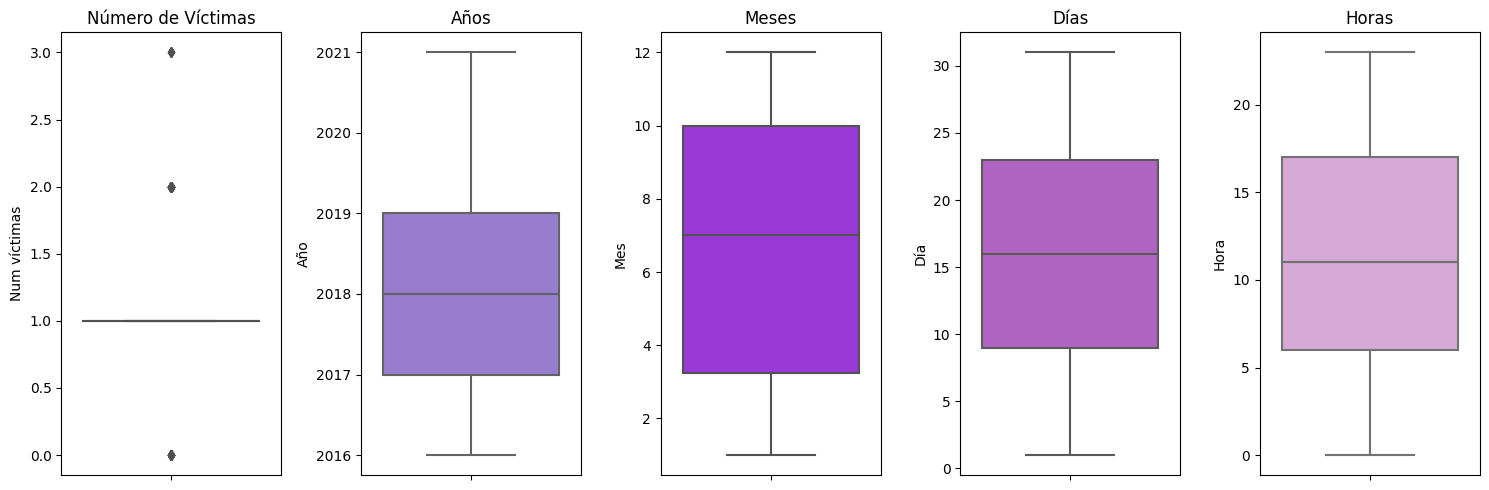

In [5]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(15, 5))

# Paleta de colores morados y sus variaciones
colors = ["#8A2BE2", "#9370DB", "#A020F0", "#BA55D3", "#DDA0DD"]

# Crear subplots para los gráficos
plt.subplot(1, 5, 1)
sns.boxplot(data=sv, y='Num víctimas', color=colors[0])
plt.title('Número de Víctimas')

plt.subplot(1, 5, 2)
sns.boxplot(data=sv, y='Año', color=colors[1])
plt.title('Años')

plt.subplot(1, 5, 3)
sns.boxplot(data=sv, y='Mes', color=colors[2])
plt.title('Meses')

plt.subplot(1, 5, 4)
sns.boxplot(data=sv, y='Día', color=colors[3])
plt.title('Días')

plt.subplot(1, 5, 5)
sns.boxplot(data=sv, y='Hora', color=colors[4])
plt.title('Horas')

# Ajustar espaciado entre subplots y mostrar gráfico
plt.tight_layout()
plt.show()

#### **Conclusión**
- Los valores atípicos detectados en `Num víctimas` (valores 2 ó 3) se presentan como resultado de que en la mayoría de las instancias, el registro es igual a uno (1) en relación con las víctimas involucradas en los incidentes.

### **Análisis - Variables Númericas**

En el conjunto de datos, se encuentran variables numéricas o aquellas que contienen números, cuyo uso como tales puede variar según el contexto de los datos.

En esta situación específica, se emplea un mapa de correlaciones para investigar posibles relaciones entre los datos numéricos o para considerar su uso como variables categóricas en ciertos casos, con el fin de realizar un análisis adecuado.

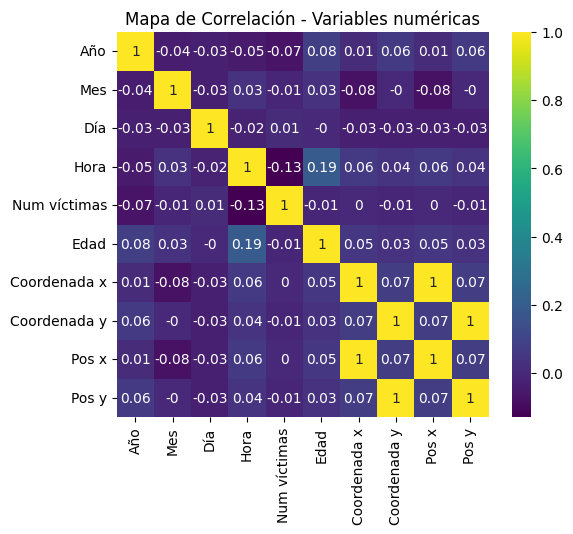

In [6]:
# Generamos un mapa de calor con las correlaciones de los todos los datos que contengan números 
mapa_calor = sv.select_dtypes(include=['number']) 
corr = mapa_calor.corr().round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="viridis", annot=True)
plt.title('Mapa de Correlación - Variables numéricas')
plt.show()

La intersección de todas las variables numéricas en la matriz revela asociaciones fuertes y positivas entre las características `Coordenada` y `Pos`, lo cual era previsible.

Además, se observa una relación **ligeramente positiva** entre la variable `Edad` y `Hora`. Las otras asociaciones muestran una correlación negativa, como era de esperar, ya que el número de víctimas en un incidente no está relacionado con una fecha u hora específica.

Dado el propósito central de este proyecto, que busca analizar los incidentes para reducir el número de víctimas mortales, se ha decidido iniciar la exploración enfocándose en la variable `Num víctimas`.

### `Num víctimas`
- Cantidad de víctimas fatales por siniestro vial

In [7]:
sv["Num víctimas"].describe()

count    717.000000
mean       1.037657
std        0.294226
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Num víctimas, dtype: float64

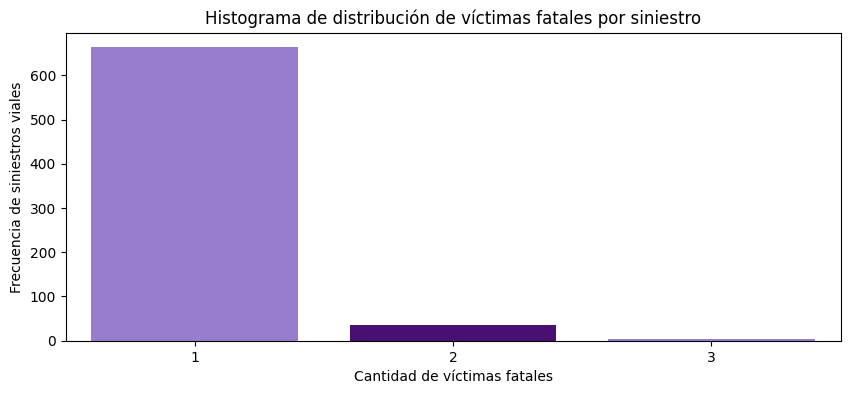

In [8]:
plt.figure(figsize=(10, 4))

# Filtrar valores nulos o sin datos
sv_filtrado = sv[sv["Num víctimas"] != 0]

# Definir una paleta con colores
colors = ["#9370DB", "#4B0082"]

# Graficar el conteo de valores
sns.countplot(sv_filtrado, x='Num víctimas', palette=colors)

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Histograma de distribución de víctimas fatales por siniestro")

plt.show()


#### **Conclusión**

- **Count (Recuento):** Hay un total de 717 entradas para esta variable.
- **Mean (Media):** La media de 'Num víctimas' es aproximadamente 1.04, lo que sugiere que en promedio, hay alrededor de una víctima por siniestro.
- **Std (Desviación estándar):** La desviación estándar de aproximadamente 0.29 indica la dispersión de los valores respecto a la media. En este caso, sugiere que la mayoría de los siniestros tienen cerca de una víctima, con poca variabilidad en torno a ese valor.
- **Min (Mínimo):** El valor mínimo es 0, lo que puede indicar casos sin víctimas.
- **25%, 50% y 75% (Cuartiles):** Estos percentiles revelan que el 75% de los siniestros tienen hasta una víctima.
- **Max (Máximo):** El valor máximo registrado es 3, lo que sugiere que algunos incidentes tienen hasta tres víctimas.

En resumen, la mayoría de los siniestros viales tienen una o ninguna víctima, con poca variabilidad alrededor de esa cantidad. Sin embargo, existen casos en los que se registran hasta tres víctimas en un solo siniestro.

#### **Relación `Num vìctimas` con el tiempo - Distribución temporal**

Se examinan los datos considerando diversos intervalos temporales con el fin de verificar la presencia de eventos significativos o patrones relevantes.

In [9]:
# Agrupar por año y mes, y sumar el número de víctimas
tiempos = sv.groupby(['Año', 'Mes'])['Num víctimas'].sum().reset_index()

In [10]:
tiempos

,Año,Mes,Num víctimas
0,2016.0,1.0,8
1,2016.0,2.0,12
2,2016.0,3.0,15
3,2016.0,4.0,9
4,2016.0,5.0,7
...,...,...,...
67,2021.0,8.0,9
68,2021.0,9.0,4
69,2021.0,10.0,5
70,2021.0,11.0,8


In [11]:
# Se convierten los datos al tipo 'int' para crear la visualización gráfica.
tiempos["Año"]= tiempos["Año"].astype("Int64")
tiempos["Mes"]= tiempos["Mes"].astype("Int64")
tiempos

,Año,Mes,Num víctimas
0,2016,1,8
1,2016,2,12
2,2016,3,15
3,2016,4,9
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [12]:
# Fusionar los valores de AÑO y MES para formar una variable temporal única, generando la columna "Fecha" como una cadena de texto (str).
tiempos["Fecha"] = tiempos["Año"].astype(str) + '-' + tiempos["Mes"].astype(str)

# Transformar la variable temporal al formato de fecha y hora
tiempos["Fecha"] = pd.to_datetime(tiempos["Fecha"])

# Organizar el DataFrame según la fecha para establecer un orden cronológico.
tiempos = tiempos.sort_values("Fecha")

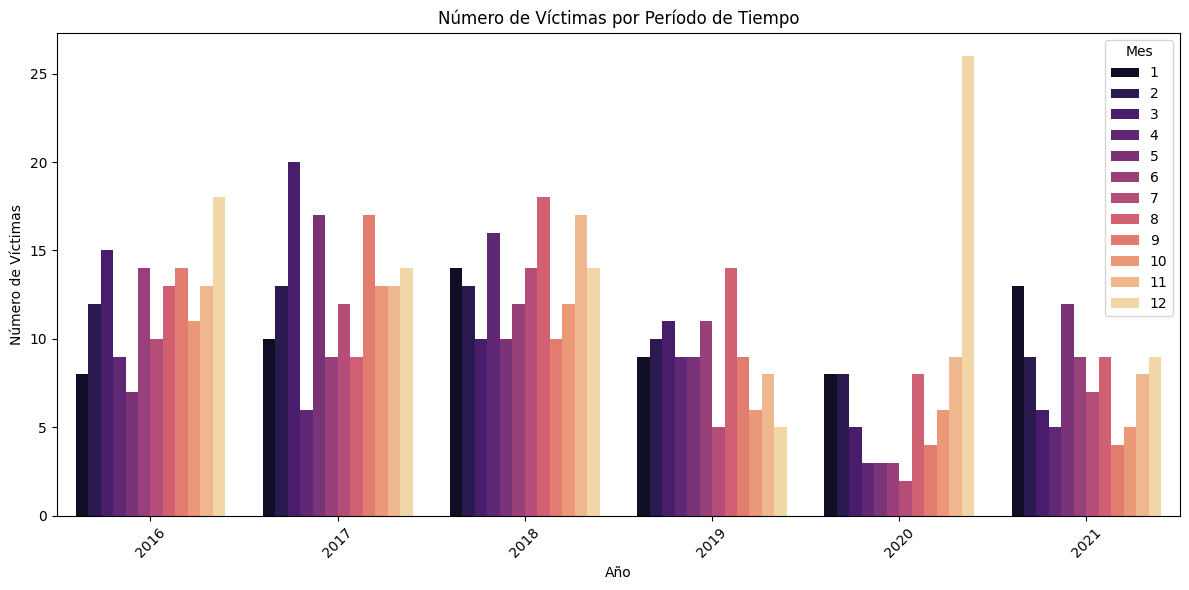

In [61]:
# Agrupar por año y mes, contando el número de víctimas en cada período
grouped = tiempos.groupby(['Año', 'Mes'])['Num víctimas'].sum().reset_index()

# Crear el gráfico de barras agrupadas por año y mes
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Año', y='Num víctimas', hue='Mes', palette='magma')

# Añadir títulos y etiquetas
plt.title('Número de Víctimas por Período de Tiempo')
plt.xlabel('Año')
plt.ylabel('Número de Víctimas')
plt.legend(title='Mes')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### **Conclusión**

- El gráfico muestra la evolución temporal del número de víctimas revelando que los años con mayor cantidad de siniestros fatales fueron 2017 y 2018, seguidos de una reducción continua en los años subsiguientes. Sin embargo, se identifica un aumento considerable hacia finales de 2020, superando el máximo histórico mensual de víctimas con 26 fallecimientos en un mes.
- Durante el año 2020, la llegada de la pandemia COVID-19 tuvo un impacto significativo en las estadísticas de siniestros viales.

### **Distribución temporal de víctimas**

- #### Distribución mensual de víctimas fatales

Se genera un gráfico de barras que exhibe el recuento de víctimas por mes, incluyendo etiquetas que muestran el número de víctimas en cada barra.

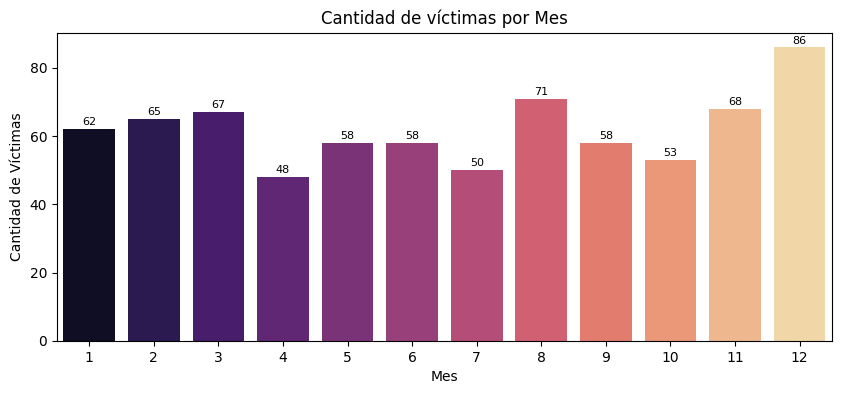

In [26]:
# Se agrupa por la cantidad de víctimas por mes
data = sv.groupby(['Mes'])['Num víctimas'].sum().reset_index()
data["Mes"] = data["Mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(10, 4))

ax = sns.barplot(x='Mes', y='Num víctimas', data=data, palette="magma")
ax.set_title('Cantidad de víctimas por Mes')
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

- #### Distribución diaria de víctimas fatales

Se genera un gráfico de barras que exhibe el recuento de víctimas por día, incluyendo etiquetas con el número de víctimas en cada barra.

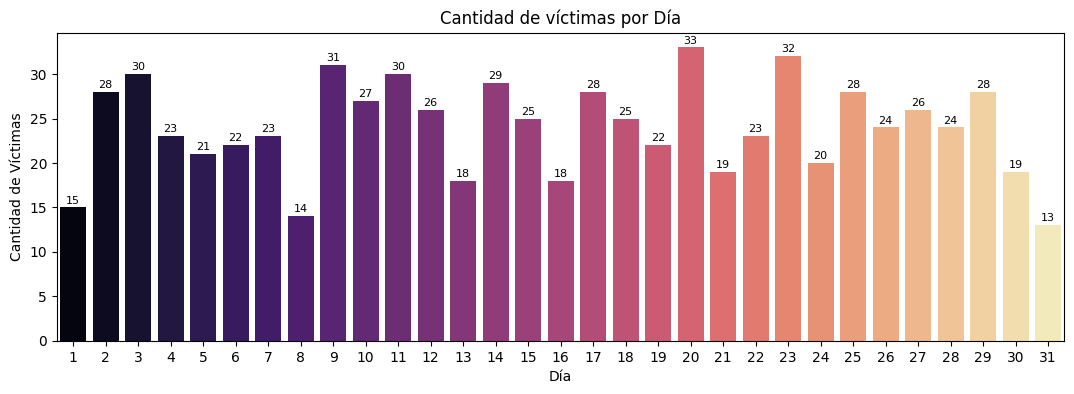

In [28]:
# Se realiza una agrupación según el número de víctimas por día.
data = sv.groupby(['Día'])['Num víctimas'].sum().reset_index()
data["Día"]=data["Día"].astype("Int64")

# Se crea la representación gráfica.
plt.figure(figsize=(13,4))

ax = sns.barplot(x='Día', y='Num víctimas', data=data, palette="magma")
ax.set_title('Cantidad de víctimas por Día')
ax.set_xlabel('Día') ; ax.set_ylabel('Cantidad de Víctimas')

# Se añaden etiquetas que muestran el número de víctimas en cada barra.
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se visualiza el gráfico
plt.show()

Se genera un gráfico de barras que exhibe el recuento de víctimas por día de la semana, incluyendo etiquetas con el número de víctimas en cada barra.

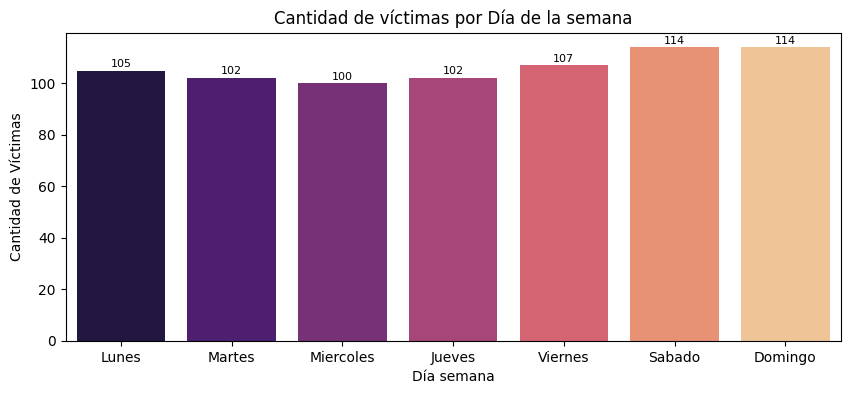

In [29]:
# Se agrupa por la cantidad de víctimas por dia semana
data = sv.groupby(['Día semana'])['Num víctimas'].sum().reset_index()


# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')



# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Día semana', y='Num víctimas', data=data, palette="magma")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('Día semana') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

- #### Distribución relacionando horas y días, de víctimas fatales

Se genera un gráfico de mapa de calor en el que el eje horizontal refleja las horas del día, el eje vertical muestra los días de la semana, y el color de cada cuadrado denota la cantidad de víctimas. La visualización utiliza Seaborn y la opción annot=True para incluir los valores numéricos dentro de cada celda del mapa de calor.

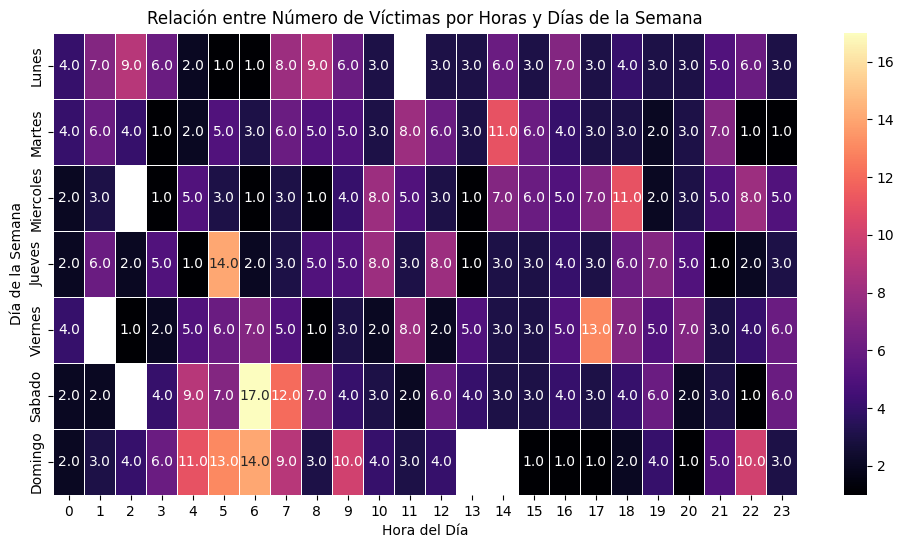

In [31]:
#Agrupa los datos en cantidad de victimas por dia de la semana y horas 
data = sv.groupby(['Día semana', "Hora"])['Num víctimas'].sum().reset_index()
data["Hora"]=data["Hora"].astype("Int64")

# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')

# Crear una tabla pivot para los datos
pivot_data = data.pivot_table(index= 'Día semana', columns='Hora', values='Num víctimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='magma', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()


#### **Conclusión**

- Diciembre registró la mayor cantidad de `víctimas fatales` (86) en comparación con otros meses.
- El día 20 sobresale con el mayor número de víctimas, mientras que los fines de semana, específicamente los sábados y domingos, representan conjuntamente 114 víctimas fatales, la mayor cantidad esto podría deberse a que las personas suelen pasar más tiempo fuera de casa los fines de semana.
- El mapa de calor indica que los fines de semana, especialmente los sábados y domingos, muestran números más elevados de víctimas fatales, sobre todo entre las 3:00 y las 9:00 horas.
- Los horarios con mayor riesgo parecen vincularse con las horas de entrada laboral (05:00 - 09:00), el mediodía (12:00 - 14:00) y el cierre de la jornada laboral (17:00 - 18:00). En las primeras horas de la madrugada se registran pocos incidentes. Los fines de semana tienen menos accidentes, pero con mayor gravedad en términos de víctimas.

### **`Edad` de las víctimas**

Se genera un histograma que representa las edades de las víctimas fatales, combinado con un gráfico de cajas (boxplot) que utiliza el mismo eje para mostrar las estadísticas de la distribución de edades.

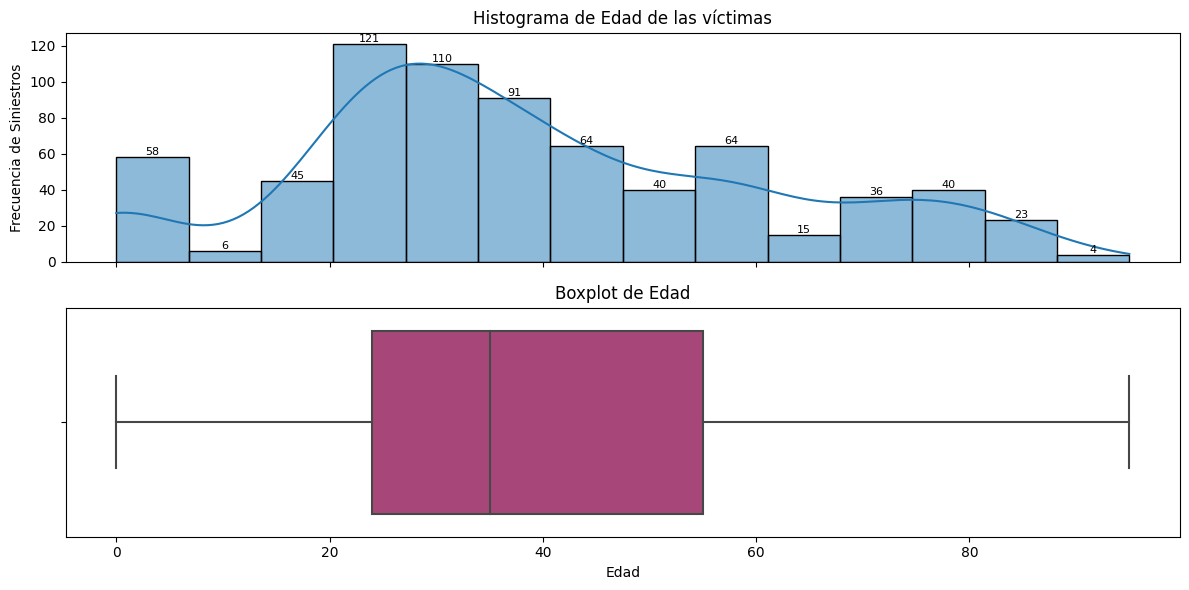

In [37]:
# Se crea una figura con un solo eje x compartido para tener dos gráficos en uno
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Se grafica el histograma de la edad
sns.histplot(sv['Edad'], kde=True, ax=ax[0]) #se agrega la línea de suavizado
ax[0].set_title('Histograma de Edad de las víctimas') ; ax[0].set_ylabel('Frecuencia de Siniestros')

# Agregar etiquetas de datos en el histograma
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')

# Se grafica el boxplot de la edad
sns.boxplot(x=sv['Edad'], ax=ax[1], palette='magma')
ax[1].set_title('Boxplot de Edad') ; ax[1].set_xlabel('Edad')

# Se ajusta y muestra el gráfico
plt.tight_layout()
plt.show()


In [38]:
sv["Edad"].describe()

count    717.000000
mean      39.050209
std       22.010669
min        0.000000
25%       24.000000
50%       35.000000
75%       55.000000
max       95.000000
Name: Edad, dtype: float64

En una visualización en general se puede observar la siguiente información:

- El recuento total de observaciones es de 717 registros.
- La edad media de las víctimas fatales es aproximadamente 39 años.
- La dispersión de las edades está representada por la desviación estándar, que es alrededor de 22 años.
- La edad máxima registrada es de 95 años.
- Los cuartiles indican la distribución de las edades: el 25% de las víctimas tenía hasta 24 años, el 50% hasta 35 años y el 75% hasta 55 años.

### **Relación de `Edad` de las víctimas con la `Hora` y `Sexo` del siniestro**

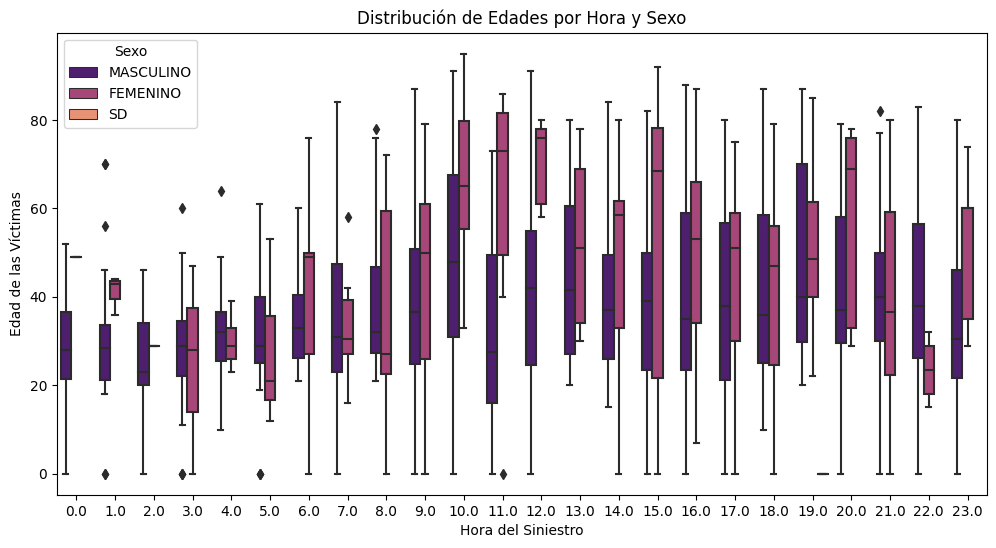

In [54]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sv, x='Hora', y='Edad', hue='Sexo', palette='magma')
plt.xlabel('Hora del Siniestro')
plt.ylabel('Edad de las Víctimas')
plt.title('Distribución de Edades por Hora y Sexo')
plt.legend(title='Sexo')
plt.show()

#### **Conclusiones**
- Los gráficos de dispersión evidencian una correlación entre las edades de 20 a 40 años de las víctimas y las franjas horarias con mayor frecuencia de siniestros viales, principalmente entre las 5 y las 9 de la mañana, así como entre las 17 y las 18 horas.
- Al introducir la variable de sexo, se observa que la cantidad de víctimas masculinas supera a la femenina en esta relación.

### **Distribución etaria  de víctimas según `Sexo`**

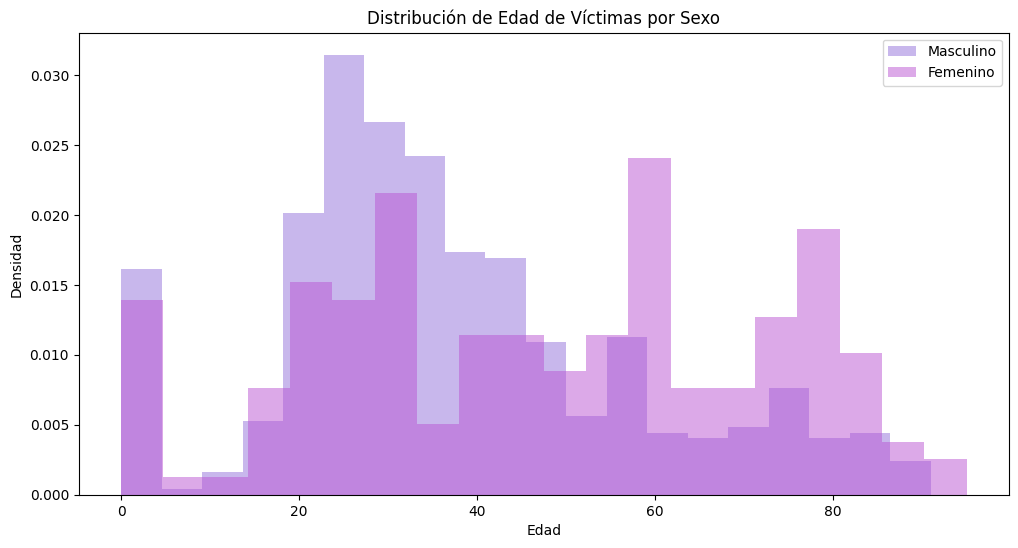

In [65]:
# Filtrar por sexo masculino
masculino = sv[sv['Sexo'] == 'MASCULINO']['Edad'].dropna()

# Filtrar por sexo femenino
femenino = sv[sv['Sexo'] == 'FEMENINO']['Edad'].dropna()

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.hist(masculino, bins=20, alpha=0.5, color='#9370DB', label='Masculino', density=True)
plt.hist(femenino, bins=20, alpha=0.5, color='#BA55D3', label='Femenino', density=True)
plt.title('Distribución de Edad de Víctimas por Sexo')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()
plt.show()

#### **Conclusión**
El gráfico presenta dos histogramas combinados para facilitar la comparación entre las víctimas de ambos sexos. 
- Los datos sugieren que las víctimas masculinas se concentran entre los 20 y los 40 años, mientras que las femeninas tienden a distribuirse en rangos de edades de 40, 60 y 80 años.

### **Distribución temporal de las Edades de las víctimas**

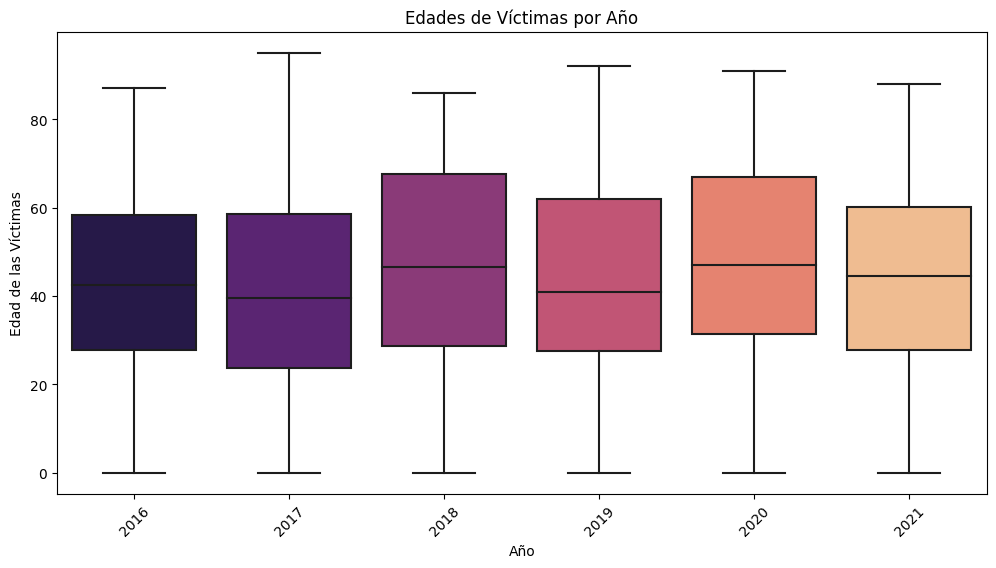

In [67]:
# Se crea el gráfico de boxplot con el DataFrame agrupado
plt.figure(figsize=(12, 6))
sns.boxplot(x='Año', y='Edad', data=data, palette="magma")

plt.title('Edades de Víctimas por Año')
plt.xlabel('Año')
plt.ylabel('Edad de las Víctimas')
plt.xticks(rotation=45)
plt.show()


#### **Conclusión**
El gráfico confirma que a través del tiempo, la mediana de la edad de las víctimas sigue siendo alrrededor de los 39 años y supera esta barrera en el año 2020

### Distribución espacial de los siniestros con víctimas `Coordenadas`

Para usar Geopandas, primero se define un sistema de referencia de coordenadas (CRS) y éste le dice a Python como se relacionan estas coordenadas que instanciamos con los diferentes lugares del planeta

In [68]:
# Iniciamos CRS

crs={'init':'epsg:4326'}

In [70]:
#Definimos la geometría según nuestro dataset
geometry=[Point(xy) for xy in zip(sv["Pos x"], sv["Pos y"])]

c:\Users\Mayra\Desktop\PIDA\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

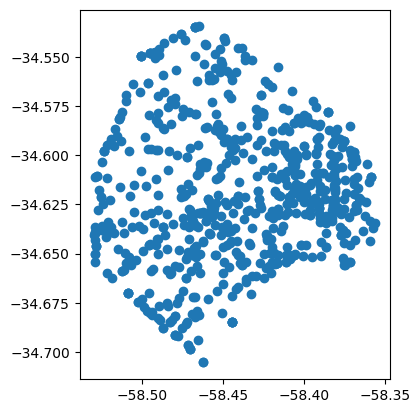

In [71]:
#Ua vez que tenemos el sistema de referencia decoordenadas y la geometría; se procede a la carga de los datos
geodata=gpd.GeoDataFrame(sv,crs=crs, geometry=geometry)

#Se imprime el resultante que luego será introducido en un mapa
geodata.plot()

Una vez que el mapa de geometría está listo, se debe cargar el archivo de las comunas del la ciudad de Buenos Aires que se extrajo de https://data.buenosaires.gob.ar/dataset/comunas/resource/Juqdkmgo-612222-resource que debe ser un archivo Shapefile (SHP)

In [ ]:
#Extraer el archivo
shapefile = gpd.read_file(r"dataset/comunas_wgs84.shp")

Text(158.98305973900304, 0.5, 'Latitud')

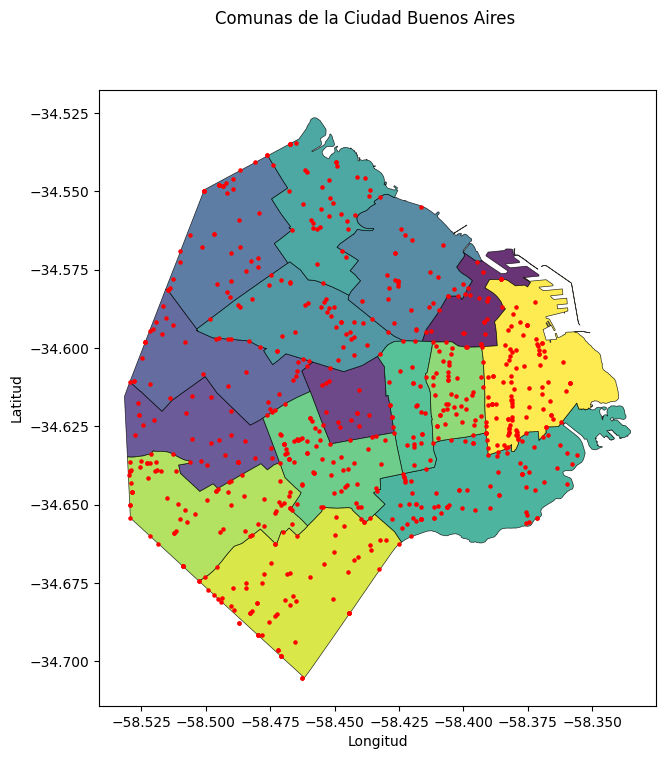

In [ ]:
#Se realiza sobre el mapa de CABA la presentación de los puntos de referencia a los siniestros viales

#Crea ejes y figuras
fig, ax = plt.subplots(figsize=(10,8))

#Dibujar el Shapefile
shapefile.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=0.8,linewidth=0.5,cmap="viridis")

#Dibujar los datos geoespaciales
geodata.plot(ax=ax, color='red', markersize=5);

#Agregar título y etiquetas de ejes
fig.suptitle('Comunas de la Ciudad Buenos Aires', fontsize=12)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize='medium')

#### **Conclusión**
- La gráfica muestra la concentración de los puntos rojos representando siniestros con víctimas fatales, hacia la zona Este del mapa de CABA sobre la comuna 1 y 4

### B - Variables Categóricas

### Distribución por `Comuna`

In [28]:
#Se crea un dataset con el número de víctimas por Barrio y Comuna
Total_comuna=df.groupby(["Comuna", "Barrios"])["Num víctimas"].sum().reset_index()
Total_comuna=Total_comuna.sort_values(by="Num víctimas", ascending=False)
Total_comuna

,Comuna,Barrios,Num víctimas
0,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,101
9,Comuna 4,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,81
14,Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,74
13,Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,70
12,Comuna 7,FLORES - PARQUE CHACABUCO,65
8,Comuna 3,BALVANERA - SAN CRISTOBAL,48
6,Comuna 15,AGRONOMIA - CHACARITA - PARQUE CHAS - PATERN...,47
3,Comuna 12,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,43
4,Comuna 13,BELGRANO - COLEGIALES - NUÃ‘EZ,39
5,Comuna 14,PALERMO,38


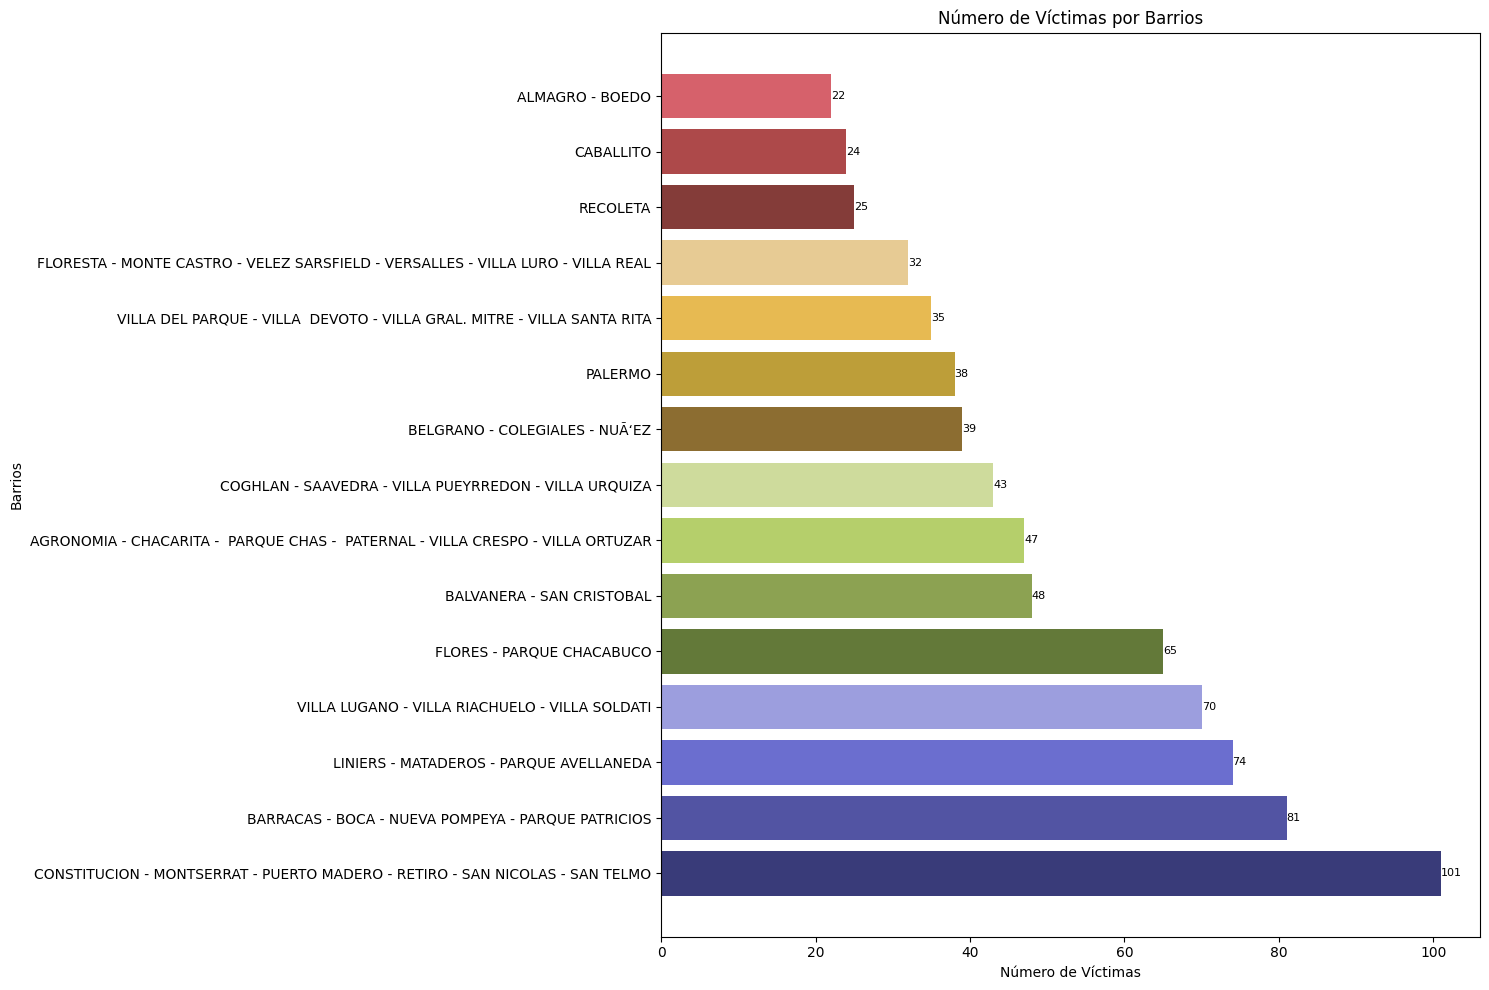

In [38]:
# Crear el gráfico de barras horizontales
plt.figure(figsize=(15, 10))

# Colores para las barras
colores = plt.cm.tab20b(range(len(Total_comuna)))

# Dibujar las barras horizontales
plt.barh(Total_comuna["Barrios"], Total_comuna["Num víctimas"], color=colores)

# Etiquetas de eje x e y
plt.xlabel('Número de Víctimas')
plt.ylabel('Barrios')

# Título del gráfico
plt.title('Número de Víctimas por Barrios')

# Agregar el número de víctimas sobre cada barra
for i, v in enumerate(Total_comuna["Num víctimas"]):
    plt.text(v, i, str(v), va='center', fontsize=8, color='black')


plt.tight_layout()
plt.show()

#### **Conclusión**
- El dataset presenta el total de 15 comunas que conforman los distintos barrios de CABA. Cada comuna esta formada por uno o varios Barrios.
- De la tabla `Total_comunas` resultan con mayor cantidad de víctimas fatales las Comunas 1, 4, 9, 8 y 7.
- La comuna 1 supera por 20 en víctimas a la comuna 4, que le sigue en orden 

Ello sugiere que pueden ser Barrios donde existan arterias muy transitadas al momento de la entrada ó salida del horario laboral

### Distribución de los `Tipos de Calles` donde suceden los siniestros

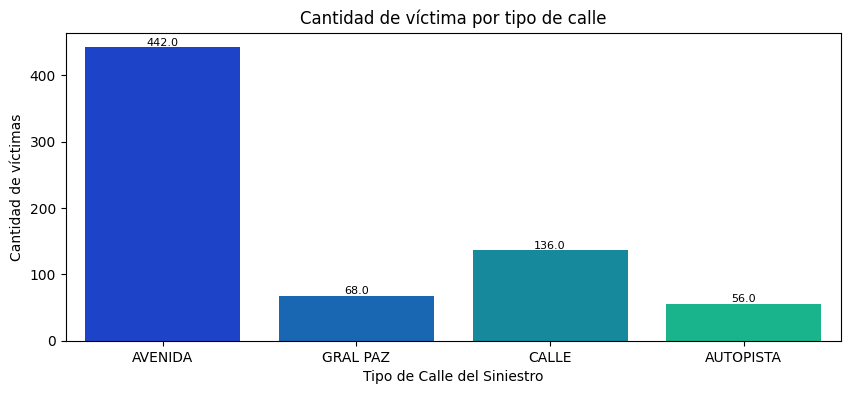

In [43]:
#Se crea el gráfico de barras
plt.figure(figsize=(10, 4))

ax=sns.countplot(df, x='Tipo de calle', palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se titulan los ejes
plt.xlabel('Tipo de Calle del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctima por tipo de calle')

plt.show()

#### **Conclusión**
- Del análisis del gráfico resulta que el mayor número de víctimas fatales se producen en `Avenida`; secundado por `Calle`.

### Distribución de `Participantes` en los siniestros

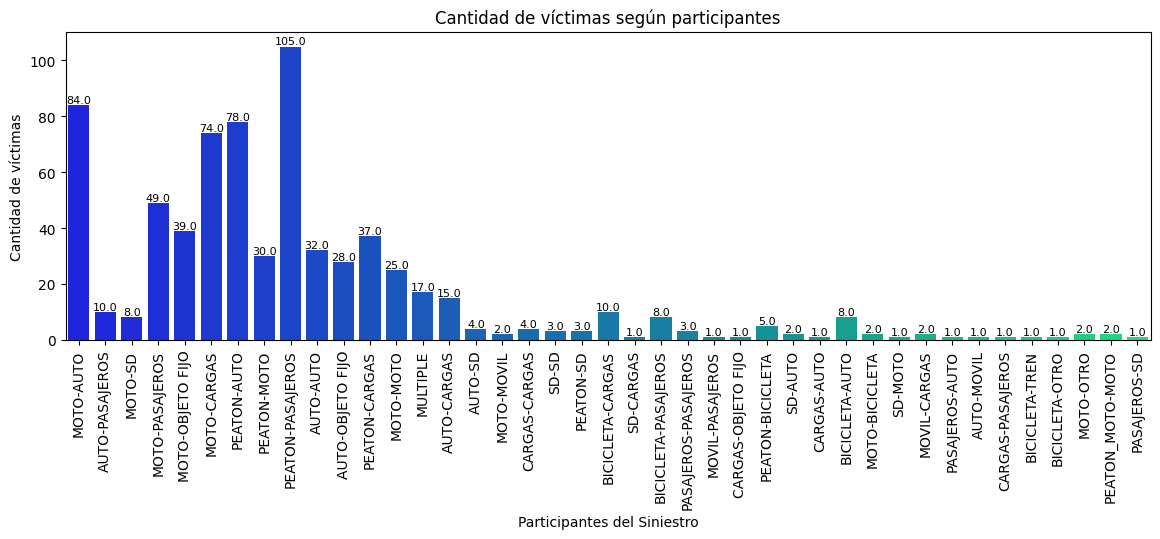

In [47]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Participantes", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se ubican los titulos de las barras en 90 grados
plt.xticks(rotation=90)

#Se titulan los ejes
plt.xlabel('Participantes del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según participantes')

plt.show()

#### **Conclusión**
- Los valores de participación que concentran más víctimas están en `PEATON-PASAJEROS`, esto según el diccionario de datos, se refiere a Peatón: es cualquier víctima distinta de cualquier ocupante de un vehículo; Pasajero: es cualquier persona que se encuentra dentro, descendiendo o ascendiendo del transporte público u omnibús de larga distancia.
- Le siguen en importancia de víctimas `MOTO-AUTO` , `PEATON-AUTO` y `MOTO-CARGAS`

En la columna `Participantes` puede interpretarse que la primer palabra se relaciona a quien fue la `Víctima` y la segunda palabra se refiere al `Acusado`

### Distribución de `Acusados` en los siniestros

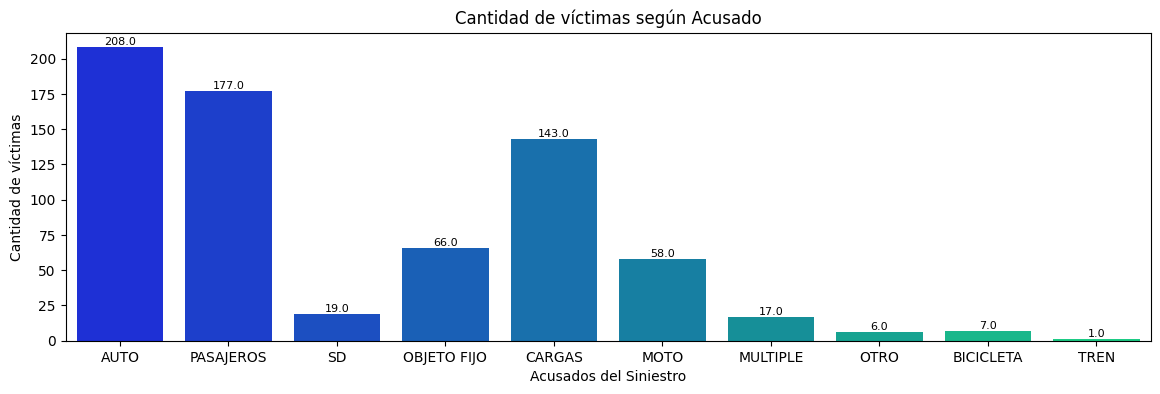

In [49]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Acusado", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Acusados del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según Acusado')

plt.show()

#### **Conclusión**
- Se puede visualizar que los que causan más víctimas son los  `Autos`, `Cargas` y `Pasajeros`. Esto se relaciona con el punto anterior.

### Distribución de `Víctimas` en los siniestros

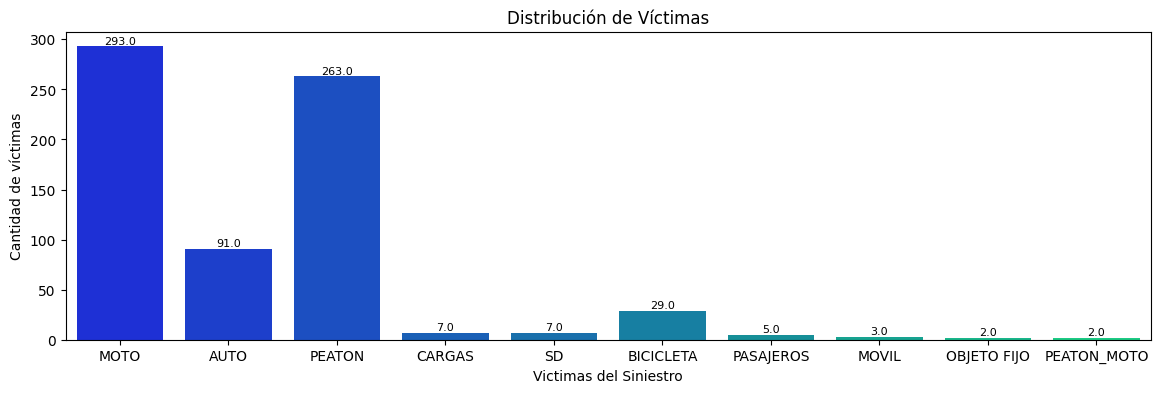

In [50]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Victima", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Victimas del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Distribución de Víctimas')

plt.show()

#### **Conclusión**
- Se puede visualizar que las víctimas son  `Moto`, `Peaton` y `Carga`. Esto se relaciona con ambos puntos anteriores.

### Matriz de confusión 

Se crea una tabla ce contingencia que relacione los datos de las columnas `Víctima` y `Acusado` para analizar de manera más visual los datos de los siniestros y sus participantes.

In [51]:
tabla_contingencia = pd.crosstab(df['Victima'], df['Acusado'])

# Visualizar la tabla de contingencia
tabla_contingencia

Acusado,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
Victima,,,,,,,,,,
AUTO,32,0,15,0,3,26,1,10,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,84,2,74,25,8,39,4,49,8,0
MOVIL,0,0,2,0,0,0,0,1,0,0
OBJETO FIJO,2,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,78,5,37,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,2,0,0,0,0,0,0


#### **Conclusión**
Aquí se encuentran de manera más clara en sus resultados la intervención en cada siniestro.
- Cuando el acusado es `Auto`, la mayoría de las víctimas son Autos, Motos y Peatones.
- Cuando el acusado es `Cargas`, las victimas son variadas; siendo Motos y Peatones los más encontrados.
- Cuando el acusado es `Pasajeros`, las víctimas son principalmente Peatones y Motos.

La frecuencia de víctimas Motos y Peatones es alta, y se relacionan con casi todos los tipos de Acusados.


### Proporción de víctimas por `Sexo`

Text(0.5, 1.0, 'Proporción de Víctimas por Sexo')

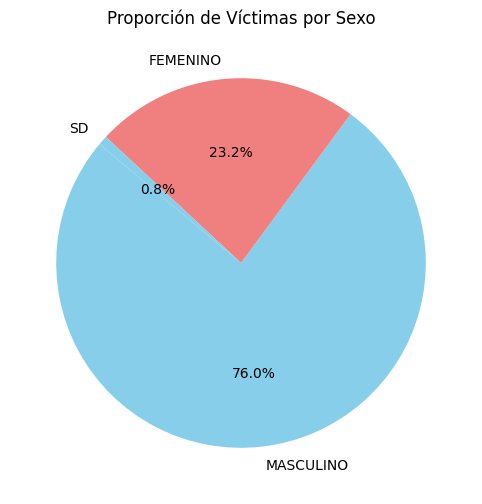

In [119]:
# Calcular la proporción de víctimas por sexo
proporcion = df['Sexo'].value_counts(normalize=True) * 100

# Preparar los datos para el gráfico de torta
labels = proporcion.index
sizes = proporcion.values

# Crear el gráfico de torta
plt.figure(figsize=(12, 6))

# Gráfico de torta

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Proporción de Víctimas por Sexo')

### Distribución de los roles de las víctimas por `Sexo`

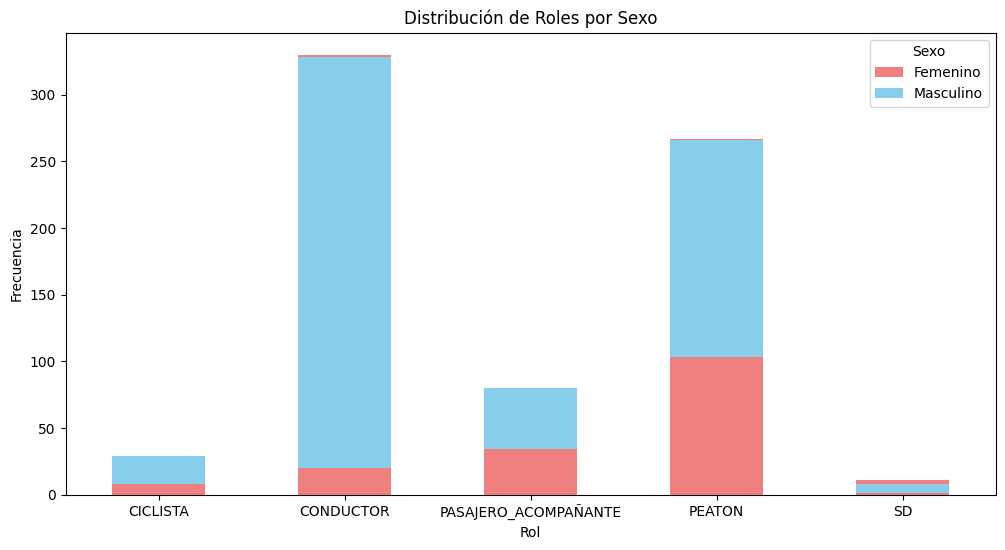

In [130]:
# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(df['Rol'], df['Sexo'])

# Crear un gráfico de barras apiladas
ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightcoral",'skyblue'])
plt.title('Distribución de Roles por Sexo')
plt.xlabel('Rol')
plt.ylabel('Frecuencia')

# Agregar una leyenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Femenino', 'Masculino'], title='Sexo')

plt.xticks(rotation=0)
plt.show()

#### **Conclusión**
La distribución por roles de las víctimas muestra que
- la mayor cantidad de siniestros las victimas tienen como rol `Conductor`, seguida por `Peatón`.
- para las víctimas de sexo `Masculino`, el rol más frecuente en los siniestros es como conductor, seguido por peatón.
- para las víctimas de sexo `Femenino`, el rol más frecuente en los siniestros es como peatón, seguido por pasajero-acompañante

### Distribucíon de víctimas según `sexo` y `tipo de vehículo`

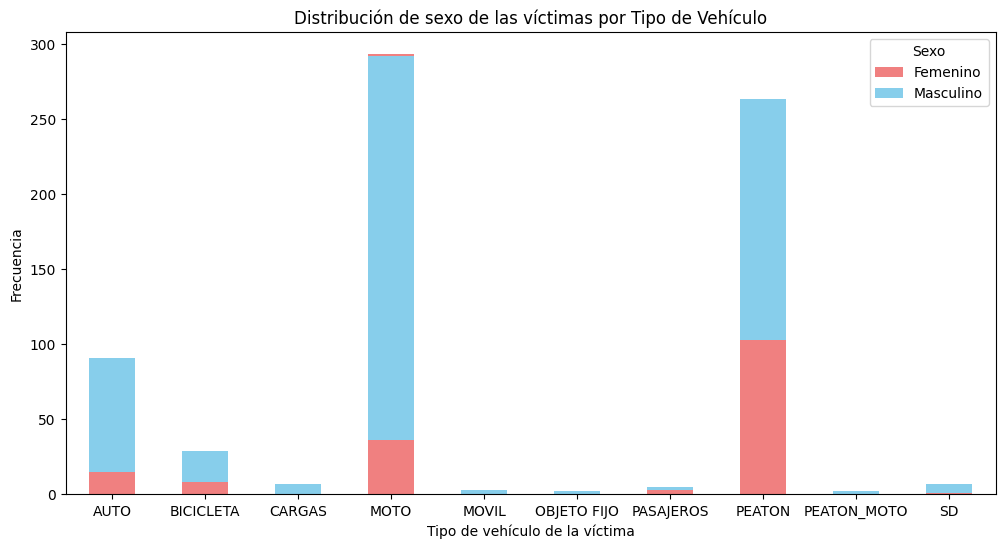

In [4]:
# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(df['Victima'], df['Sexo'])

# Crear un gráfico de barras apiladas
ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightcoral",'skyblue'])
plt.title('Distribución de sexo de las víctimas por Tipo de Vehículo')
plt.xlabel('Tipo de vehículo de la víctima')
plt.ylabel('Frecuencia')

# Agregar una leyenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Femenino', 'Masculino'], title='Sexo')

plt.xticks(rotation=0)
plt.show()

#### **Conclusión**

- La mayor cantidad de accidentes con víctimas fatales son en `Moto` y además con más proporción de Masculinos
- Los `Peatones`, son el segundo tipo de víctima, en el que la mayor proporción son Masculinos pero con menor diferencia que en la primera.